In [1]:
# Load the libraries

!pip install indic-nlp-library

from indicnlp.tokenize import indic_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth',None)   #this displays the dataframe in full width
import collections
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
import nltk
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 604.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 9.0 MB/s eta 0:00:00


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load dataset from Google Drive

df_authentic = pd.read_csv('/content/drive/MyDrive/Research/IIT_BHU/authentic.csv')
df_fake = pd.read_csv('/content/drive/MyDrive/Research/IIT_BHU/fake.csv')

df_authentic['label'] = 'Authentic'
df_fake['label'] = 'Fake'
df = pd.concat([df_authentic, df_fake], axis='rows')
df.head()
df.columns = ['URL', 'Title', 'Authors', 'Keywords', 'Summary', 'label']

,Unnamed: 0,URL,Title,Authors,Summary,Keywords,dates,label
0,0,https://hindi.oneindia.com/news/india/when-aamir-khan-did-not-talk-to-juhi-chawla-for-7-years-fight-over-the-shooting-of-the-film-ishq-608218.html,"जब जूही चावला से आमिर खान ने 7 सालों तक नहीं की बात, फिल्म 'इश्क' की शूटिंग पर हुआ था झगड़ा",['Oi-Akarsh Shukla'],"सात सालों तक एक दूसरे से नहीं की बातआपको जानकर हैरानी होगी कि सुपरहिट फिल्म से बॉलीवुड में अपने करियर की शुरुआत करने वाले आमिर खान ने जूही चावला से करीब छह-सात साल तक बात नहीं की थी। जैसा कि हम सभी जानते हैं आमिर और जूही 90 के दशक के सुपर हिट जोड़ियों में से एक थे, आमिर खान ने सुपरहिट फिल्म 'कयामत से कयामत तक' से बॉलीवुड में डेब्यू किया तो जूही चावला ने फिल्म सल्तनत से फिल्म इंडस्ट्री में डेब्यू किया था। इसके बाद दोनों ने कई हिट फिल्में साथ कीं।जब आमिर और जूही की हुई थी लड़ाईजूही चावला से हुई अपनी लड़ाई को याद करते हुए आमिर खान ने रविवार को बताया, फिल्म 'इश्क' की शूटिंग के दौरान हमारी छोटी सी बहस हो गई थी। लड़ाई छोटी थी लेकिन मुझे लगता है, उस दौरान में थोड़ा घमंडी था। मैंने फैसला किया कि मैं उनसे (जूही) से कभी बात नहीं करूंगा। सेट्स पर भी मैं उससे दूरी बनाए रखता। मुझे नहीं पता कि मैंने ऐसा क्यों किया।शूट पर जूही से 50 फीट दूर बैठते थे आमिरआमिर खान ने आगे कहा, 'जब वह आती और मेरे पास बैठती तब भी मैं बाहर निकल जाता। हंसते हुए आमिर ने कहा, मैं जूही से कम से कम 50 फीट दूर बैठता था। मैंने कभी भी उनके अभिवादन का जवाब नहीं दिया, ना ही कभी मैंने पहल की। सिर्फ शूटिंग के समय हमारा बात करना जरूरी था, तो मैं सिर्फ प्रोफेशनली जूही से बात करता था।' एक्टर ने कहा, 'हमने करीब छह-सात साल तक बात नहीं की। लेकिन जब 2002 में रीना दत्ता संग मेरे तलाक की खबर मिली तब उन्होंने मुझे फोन किया और मिलने के लिए कहा।'पत्नी से तलाक होने के बाद आमिर को किया फोनआमिर बताते हैं, 'जूही शुरू से ही मेरे और रीना के करीब रही थी, वह हमारे मतभेदों को सुलझाना चाहती थी। जूही को शायद पता था कि मैं उसका फोन शायद ना उठाऊं, लेकिन फिर भी उसने मुझे फोन किया। इस बात ने मुझे छू लिया और मैं जानता था कि हमारी दोस्ती कभी टूटी नहीं थी। हम शायद बात नहीं करते थे लेकिन एक दूसरे का ख्याल फिर भी रखते थे।' आमिर खान के जन्मदिन पर जूही ने उनसे मुलाकात कर जन्मदिन विश किया।","['न', 'स', 'बत', 'म', 'कय', 'शटग', 'हआ', 'नह', 'फलम', 'पर', 'क', 'सल', 'थ', 'जह', 'आमर']",2021-03-14 19:01:09,Authentic
1,1,https://hindi.oneindia.com/news/india/ec-suspends-mamata-s-chief-of-security-over-nandigram-injury-charges-to-be-framed-608217.html,"नंदीग्राम हमले पर चुनाव आयोग की बड़ी कार्रवाई, हटाए गए ममता बनर्जी के सुरक्षा निदेशक",['Oi-Ankur Kumar'],"ममता बनर्जी की फोटो शेयर कर बोले प्रकाश राज, \""मैं जयकांत शिकरे बोल रहा हूं\""पश्चिम बंगाल में बोले शाह- मुझे ममता की चोट का एहसास, लेकिन क्‍या दीदी को है BJP वर्कर्स की हत्या का दर्दपश्चिम बंगाल चुनाव: ममता को बड़ा झटका, MLA देबश्री रॉय ने दिया इस्‍तीफा, कई नेता बीजेपी में शामिलपश्चिम बंगाल चुनाव: पुरुलिया में बोलीं ममता बनर्जी- मेरा दर्द लोगों की परेशानियों के सामने कुछ भी नहींबंगाल चुनाव: गडकरी बोले- बंगाल भुखमरी, गरीबी से पीड़ित है यहां डबल इंजन सरकार बनी तो जबरदस्‍त विकास लाएगीTMC, CPM से बगावत कर BJP में आए ज्यादातर नेताओं को मिली CISF सिक्योरिटी, जानिए कौन-कौन हैं शामिलनंदीग्राम हमले पर चुनाव आयोग की बड़ी कार्रवाई, हटाए गए ममता बनर्जी के सुरक्षा निदेशकIndiaoi-Ankur Kumarकोलकाता। पश्चिम बंगाल की मुख्‍यमंत्री और टीएमसी मुखिया ममता बनर्जी पर नंदीग्राम में हुए हमले को लेकर राजनीतिक घमासान मचा हुआ है। इस मामले को लेकर आयोग ने रविवार को विशेष बैठक बुलाई थी। बैठक में चुनाव आयोग ने एक्शन लेते हुए ममता बनर्जी के सिक्योरिटी डायरेक्टर विवेक सहाय को पद से हटा दिया है। बैठक में चुनाव आयोग ने कहा कि ममता की Z+ सुरक्षा निदेशक के रूव में अपने प्राथमिक कर्तव्‍य के निर्वहन में विफल रहने के लिए एक सप्‍ताह के भीतर सहाय के खिलाफ आरोप तय होना चाहिए।विवेक सहाय के अलावा चुनाव आयोग ने पूर्वी मिदनापुर के डीएम विभू गोयल और एसपी प्रवीण प्रकाश को भी पद सक हटा दिया है। इन सबपर कर्तव्‍य पालन में लापरवाही बरतने का अरोप है। विभू गोयल की जगह 2005 बैच की आईएएस अधिकारी स्मिता पांडे लेंगी। वहीं प्रवीण प्रकाश की जगह 2009 बैच के आईपीएस सुनील यादव कमान संभालेंगे। इसी के साथ इन कार्रवाईयों के चलते चुनाव आयोग ने ये संकेत दिया कि मुख्यमंत्री ममता बनर्जी पर नंदीग्राम में हुआ हमला पू

In [ ]:
# Assuming 'df' is your DataFrame containing the dataset
num_records = len(df_authentic)

print(f"The dataset has {num_records} records.")

The dataset has 6157 records.


In [ ]:
df = df.drop(['URL', 'Title', 'Authors', 'Keywords','dates'] ,axis=1)
df = df.reset_index()
df = df.drop('index',axis=1)

In [ ]:
def count_length():
    df['word_count'] = df['Summary'].apply(lambda x: len(str(x).split(" ")))

In [ ]:
count_length()
df.head(10)

,Unnamed: 0,Summary,label,word_count
0,0,"सात सालों तक एक दूसरे से नहीं की बातआपको जानकर हैरानी होगी कि सुपरहिट फिल्म से बॉलीवुड में अपने करियर की शुरुआत करने वाले आमिर खान ने जूही चावला से करीब छह-सात साल तक बात नहीं की थी। जैसा कि हम सभी जानते हैं आमिर और जूही 90 के दशक के सुपर हिट जोड़ियों में से एक थे, आमिर खान ने सुपरहिट फिल्म 'कयामत से कयामत तक' से बॉलीवुड में डेब्यू किया तो जूही चावला ने फिल्म सल्तनत से फिल्म इंडस्ट्री में डेब्यू किया था। इसके बाद दोनों ने कई हिट फिल्में साथ कीं।जब आमिर और जूही की हुई थी लड़ाईजूही चावला से हुई अपनी लड़ाई को याद करते हुए आमिर खान ने रविवार को बताया, फिल्म 'इश्क' की शूटिंग के दौरान हमारी छोटी सी बहस हो गई थी। लड़ाई छोटी थी लेकिन मुझे लगता है, उस दौरान में थोड़ा घमंडी था। मैंने फैसला किया कि मैं उनसे (जूही) से कभी बात नहीं करूंगा। सेट्स पर भी मैं उससे दूरी बनाए रखता। मुझे नहीं पता कि मैंने ऐसा क्यों किया।शूट पर जूही से 50 फीट दूर बैठते थे आमिरआमिर खान ने आगे कहा, 'जब वह आती और मेरे पास बैठती तब भी मैं बाहर निकल जाता। हंसते हुए आमिर ने कहा, मैं जूही से कम से कम 50 फीट दूर बैठता था। मैंने कभी भी उनके अभिवादन का जवाब नहीं दिया, ना ही कभी मैंने पहल की। सिर्फ शूटिंग के समय हमारा बात करना जरूरी था, तो मैं सिर्फ प्रोफेशनली जूही से बात करता था।' एक्टर ने कहा, 'हमने करीब छह-सात साल तक बात नहीं की। लेकिन जब 2002 में रीना दत्ता संग मेरे तलाक की खबर मिली तब उन्होंने मुझे फोन किया और मिलने के लिए कहा।'पत्नी से तलाक होने के बाद आमिर को किया फोनआमिर बताते हैं, 'जूही शुरू से ही मेरे और रीना के करीब रही थी, वह हमारे मतभेदों को सुलझाना चाहती थी। जूही को शायद पता था कि मैं उसका फोन शायद ना उठाऊं, लेकिन फिर भी उसने मुझे फोन किया। इस बात ने मुझे छू लिया और मैं जानता था कि हमारी दोस्ती कभी टूटी नहीं थी। हम शायद बात नहीं करते थे लेकिन एक दूसरे का ख्याल फिर भी रखते थे।' आमिर खान के जन्मदिन पर जूही ने उनसे मुलाकात कर जन्मदिन विश किया।",Authentic,371
1,1,"ममता बनर्जी की फोटो शेयर कर बोले प्रकाश राज, \""मैं जयकांत शिकरे बोल रहा हूं\""पश्चिम बंगाल में बोले शाह- मुझे ममता की चोट का एहसास, लेकिन क्‍या दीदी को है BJP वर्कर्स की हत्या का दर्दपश्चिम बंगाल चुनाव: ममता को बड़ा झटका, MLA देबश्री रॉय ने दिया इस्‍तीफा, कई नेता बीजेपी में शामिलपश्चिम बंगाल चुनाव: पुरुलिया में बोलीं ममता बनर्जी- मेरा दर्द लोगों की परेशानियों के सामने कुछ भी नहींबंगाल चुनाव: गडकरी बोले- बंगाल भुखमरी, गरीबी से पीड़ित है यहां डबल इंजन सरकार बनी तो जबरदस्‍त विकास लाएगीTMC, CPM से बगावत कर BJP में आए ज्यादातर नेताओं को मिली CISF सिक्योरिटी, जानिए कौन-कौन हैं शामिलनंदीग्राम हमले पर चुनाव आयोग की बड़ी कार्रवाई, हटाए गए ममता बनर्जी के सुरक्षा निदेशकIndiaoi-Ankur Kumarकोलकाता। पश्चिम बंगाल की मुख्‍यमंत्री और टीएमसी मुखिया ममता बनर्जी पर नंदीग्राम में हुए हमले को लेकर राजनीतिक घमासान मचा हुआ है। इस मामले को लेकर आयोग ने रविवार को विशेष बैठक बुलाई थी। बैठक में चुनाव आयोग ने एक्शन लेते हुए ममता बनर्जी के सिक्योरिटी डायरेक्टर विवेक सहाय को पद से हटा दिया है। बैठक में चुनाव आयोग ने कहा कि ममता की Z+ सुरक्षा निदेशक के रूव में अपने प्राथमिक कर्तव्‍य के निर्वहन में विफल रहने के लिए एक सप्‍ताह के भीतर सहाय के खिलाफ आरोप तय होना चाहिए।विवेक सहाय के अलावा चुनाव आयोग ने पूर्वी मिदनापुर के डीएम विभू गोयल और एसपी प्रवीण प्रकाश को भी पद सक हटा दिया है। इन सबपर कर्तव्‍य पालन में लापरवाही बरतने का अरोप है। विभू गोयल की जगह 2005 बैच की आईएएस अधिकारी स्मिता पांडे लेंगी। वहीं प्रवीण प्रकाश की जगह 2009 बैच के आईपीएस सुनील यादव कमान संभालेंगे। इसी के साथ इन कार्रवाईयों के चलते चुनाव आयोग ने ये संकेत दिया कि मुख्यमंत्री ममता बनर्जी पर नंदीग्राम में हुआ हमला पूर्व नियोजित नहीं था बल्‍कि सुरक्षा में चूक के चलते उन्हें चोटें आईं।इसके अलावा चुनाव आयोग ने पार्टियों के स्‍टार कंपेनर की सुरक्षा को लेकर भी गाइडलाइन जारी की। चुनाव आयोग की तरफ से कहा गया कि स्‍टार प्रचारक अगर चुनावी सभा या रैली में जाते हैं तो उस दौरान उनकी सुरक्षा का पूरा ध्‍यान रखा जाए। उन्‍हें अगर जरूरत पड़ती है तो उनको बुलेटप्रूफ गाड़ियां भी दी जाए।West Bengal Election 2021: Mamata Banerjee ने व्हीलचेयर पर बैठकर किया Road Show | वनइंडिया हिंदीVeg की जगह Nonveg पिज्जा हुआ डिलीवर, महिला ने शुद्धिकरण के लिए कंपनी से मांगा 1 करोड़ रुपए का हर्जाना",Authentic,393
2,2,"असम: कांग्रेस पर साधा राजनाथ सिंह ने निशाना, कहा- धर्म

In [ ]:
def tokenization(indic_string):
    tokens = []
    for t in indic_tokenize.trivial_tokenize(indic_string):
        tokens.append(t)
    return tokens


In [ ]:
df['Summary'] = df['Summary'].apply(lambda x: tokenization(x) if isinstance(x, str) else x)
df.head(10)


,Unnamed: 0,Summary,label,word_count
0,0,"[सात, सालों, तक, एक, दूसरे, से, नहीं, की, बातआपको, जानकर, हैरानी, होगी, कि, सुपरहिट, फिल्म, से, बॉलीवुड, में, अपने, करियर, की, शुरुआत, करने, वाले, आमिर, खान, ने, जूही, चावला, से, करीब, छह, -, सात, साल, तक, बात, नहीं, की, थी, ।, जैसा, कि, हम, सभी, जानते, हैं, आमिर, और, जूही, 90, के, दशक, के, सुपर, हिट, जोड़ियों, में, से, एक, थे, ,, आमिर, खान, ने, सुपरहिट, फिल्म, ', कयामत, से, कयामत, तक, ', से, बॉलीवुड, में, डेब्यू, किया, तो, जूही, चावला, ने, फिल्म, सल्तनत, से, फिल्म, इंडस्ट्री, में, डेब्यू, किया, था, ।, इसके, बाद, दोनों, ने, कई, हिट, फिल्में, साथ, ...]",Authentic,371
1,1,"[ममता, बनर्जी, की, फोटो, शेयर, कर, बोले, प्रकाश, राज, ,, \, "", मैं, जयकांत, शिकरे, बोल, रहा, हूं\, "", पश्चिम, बंगाल, में, बोले, शाह, -, मुझे, ममता, की, चोट, का, एहसास, ,, लेकिन, क्‍या, दीदी, को, है, BJP, वर्कर्स, की, हत्या, का, दर्दपश्चिम, बंगाल, चुनाव, :, ममता, को, बड़ा, झटका, ,, MLA, देबश्री, रॉय, ने, दिया, इस्‍तीफा, ,, कई, नेता, बीजेपी, में, शामिलपश्चिम, बंगाल, चुनाव, :, पुरुलिया, में, बोलीं, ममता, बनर्जी, -, मेरा, दर्द, लोगों, की, परेशानियों, के, सामने, कुछ, भी, नहींबंगाल, चुनाव, :, गडकरी, बोले, -, बंगाल, भुखमरी, ,, गरीबी, से, पीड़ित, है, यहां, डबल, इंजन, सरकार, बनी, तो, ...]",Authentic,393
2,2,"[असम, :, कांग्रेस, पर, साधा, राजनाथ, सिंह, ने, निशाना, ,, कहा, -, धर्म, विशेष, के, लोगों, के, समर्थन, के, लिए, AIUDF, से, किया, समझौताशरद, पवार, ने, की, 5, राज्यों, के, चुनावी, नतीजों, की, भविष्यवाणी, ,, जानें, किस, राज्य, में, बनेगी, किसकी, सरकारमध्य, प्रदेश, के, CM, शिवराज, मिशन, असम, पर, ,, BJP, प्रत्याशियों, के, लिए, करेंगे, चुनावी, सभाएं, ,, 27, को, है, वोटिंगVIDEO, :, असम, में, कांग्रेस, पर, बरसे, CM, शिवराज, ,, कहा, -, महात्मा, गांधी, नहीं, ,, जिन्ना, के, रास्ते, पर, चल, रहे, हैं, राहुलअसम, की, चुनावी, सभा, में, बोले, जेपी, नड्डा, ,, कहा, -, कांग्रेस, सत्ता, में, आने, पर, ...]",Authentic,434
3,3,"[सरवणन, को, टिकट, मिलने, से, नाराजगीरविवार, सुबह, तिरुप्पारनकुंद्रम, सीट, से, द्रमुक, मुनेत्र, कड़गम, से, विधायक, पी, सरवणन, ने, भाजपा, की, सदस्यता, हासिल, कर, ली, थी, ।, वे, 2019, में, हुए, उपचुनाव, में, तुरुप्पारनकुंद्रम, सीट, से, चुनाव, जीते, थे, ।, डीएमके, के, सीटिंग, विधायक, के, बीजेपी, ज्वाइन, करने, की, खबर, ने, जहां, सभी, को, चौंकाया, था, वहीं, सिर्फ, कुछ, घंटों, बाद, जारी, बीजेपी, उम्मीदवारों, की, सूची, में, उनका, नाम, शामिल, होने, ने, उससे, ज्यादा, चौंकाया, ।, खासकर, बीजेपी, के, स्थानीय, कार्यकर्ताओं, को, ।, मदुरई, उत्तर, सीट, से, पी, सरवणन, को, टिकट, दिए, जाने, का, बीजेपी, के, कार्यकर्ताओं, ने, विरोध, शुरू, कर, ...]",Authentic,451
4,4,"[दिल, ', धक, -, धक, गर्ल, माधुरी, दीक्षित, के, साथ, आमिर, ने, सिर्फ, एक, -, दो, ही, फिल्म, में, काम, किया, है, ।, जिसमें, दोनों, की, फिल्म, ', दिल, ', सुपरहिट, रही, थी, ।, ', दिल, ', में, भी, माधुरी, के, साथ, आमिर, खान, का, एक, बड़ा, लिपलॉक, सीन, था, ,, जिसने, पर्दे, पर, आग, लगा, दी, थी, ।, राजा, हिंदुस्तानीसाल, 1996, में, आई, ये, फिल्म, आमिर, खान, के, करियर, के, लिए, माइलस्टोन, साबित, हुई, ।, धर्मेंश, दर्शन, की, इस, फिल्म, की, सफलता, में, आमिर, -, करिश्मा, के, लिपलॉक, सीन, का, बहुत, बड़ा, हाथ, था, ।, इश्कसाल, 1997, में, आयी, ...]",Authentic,249
5,5,"[वो, ये, सब, करके, ना, सिर्फ, मजे, कर, रहे, हैं, बल्कि, इससे, मेरी, इमेज, भी, खराब, हो, रही, है, ', टाइम्स, ऑफ, इंडिया, की, खबर, के, मुताबिक, ,, गोविंदा, से, पूछा, गया, कि, द, कपिल, शर्मा, शो, में, कृष्ण, अभिषेक, आपका, मजाक, क्यों, उड़ाते, हैं, ?, \nगोविंदा, ने, कहा, ,, मुझे, नहीं, पता, कौन, उनसे, ये, सब, करवा, रहा, है, नहीं, तो, वह, अच्छे, लड़का, है, ।, वो, ये, सब, करके, ना, सिर्फ, मजे, कर, रहे, हैं, बल्कि, इससे, मेरी, इमेज, भी, खराब, हो, रही, है, ।, जो, भी, इसके, पीछे, वो, चाहता, है, हमारे, बीच, कुछ, सही, ना, हो, ...]",Authentic,343
6,6,"[असम, :, योगेंद्र, यादव, ने, की, जेल, में, बंद, राइजर, दल, के, अध्यक्ष, से, मुलाकात, ,, कहा, -, बीजेपी, को, हराना, हमारा, लक्ष्यशरद, पवार, ने, की, 5, राज्यों, के, चुनावी, नतीजों, की, भविष्यवाणी, ,, जानें, किस, राज्य, में, बनेगी, किसकी, सरकारमध्य, प्रदेश, के, CM, शिवराज, मिशन, असम, पर, ,, BJP, प्रत्याशियों, के, लिए, करेंगे, चुनावी, सभाएं, ,, 27, को, है, वोटिंगVIDEO, :, असम, में, कांग्रेस, पर, बरसे, CM

In [ ]:
stopwords_hi = [
    'और', 'का', 'में', 'है', 'की', 'से', 'हैं', 'को', 'पर', 'इस', 'होता', 'कि', 'जो',
    'कर', 'मे', 'गया', 'किया', 'रहा', 'भी', 'ने', 'नहीं', 'तो', 'ही', 'या', 'का', 'था',
    'लिए', 'लेकिन', 'सकता', 'रही', 'आप', 'सबसे', 'रहे', 'करने', 'बाद', 'हो', 'इसका',
    'था', 'इन', 'होने', 'वाले', 'बनी', 'तथा', 'उन', 'ही', 'करना', 'इतना', 'दिया', 'हो',
    'गई', 'जब', 'तक', 'थे', 'ही', 'मात्र', 'थे', 'इसी', 'तरह', 'थे', 'साथ', 'सभी', 'जो',
    'उनके', 'सकते', 'सकता', 'रहे', 'कह', 'लिया', 'हम', 'साथ', 'होते', 'व', 'थे', 'कौन',
    'हुई', 'कहता', 'जा', 'रखने', 'उसे', 'जहाँ', 'हर', 'उन्हें', 'इनके', 'होते', 'जाते',
    'कम', 'बाद', 'द्वारा', 'करना', 'अब', 'रख', 'खुद', 'सकते', 'लिया', 'जाती', 'एवं', 'वह',
    'पाए', 'इतना', 'इनका', 'लिए', 'कई', 'गए', 'होता', 'इसके', 'लिए', 'इन्हें', 'हुए',
    'उनका', 'बने', 'जाती', 'थी', 'जिसे', 'जा', 'वही', 'होना', 'किसी', 'वे', 'जिन्हें',
    'उसके', 'देख', 'कभी', 'उसकी', 'इसमें', 'हमेशा', 'करते', 'रखता', 'थे', 'रख', 'जिन्होंने'
]

stopwords_en = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
punctuations = ['nn','n', '।','/', '`', '+', '\\', '"', '?', '▁(', '$', '@', '[', '_', "'", '!', ',', ':', '^', '|', ']', '=', '%', '&', '.', ')', '(', '#', '*', '', ';', '-', '}', '|', '"']

to_be_removed = stopwords_hi + punctuations + stopwords_en


In [ ]:
summary_list = df['Summary'].tolist()  # Convert the DataFrame column to a list of lists
for i in range(len(summary_list)):
    summary_list[i] = [ele for ele in summary_list[i] if ele not in to_be_removed]

df['Summary'] = summary_list  # Reassign the modified list of lists back to the DataFrame

# Function to count the length of the summary
def count_length():
    df['word_count'] = df['Summary'].apply(len)

# Applying the function
count_length()

# Displaying the first 10 rows
df.head(10)


,Unnamed: 0,Summary,label,word_count
0,0,"[सात, सालों, एक, दूसरे, बातआपको, जानकर, हैरानी, होगी, सुपरहिट, फिल्म, बॉलीवुड, अपने, करियर, शुरुआत, आमिर, खान, जूही, चावला, करीब, छह, सात, साल, बात, जैसा, जानते, आमिर, जूही, 90, के, दशक, के, सुपर, हिट, जोड़ियों, एक, आमिर, खान, सुपरहिट, फिल्म, कयामत, कयामत, बॉलीवुड, डेब्यू, जूही, चावला, फिल्म, सल्तनत, फिल्म, इंडस्ट्री, डेब्यू, दोनों, हिट, फिल्में, कीं, आमिर, जूही, लड़ाईजूही, चावला, अपनी, लड़ाई, याद, आमिर, खान, रविवार, बताया, फिल्म, इश्क, शूटिंग, के, दौरान, हमारी, छोटी, सी, बहस, लड़ाई, छोटी, मुझे, लगता, उस, दौरान, थोड़ा, घमंडी, मैंने, फैसला, मैं, उनसे, जूही, बात, करूंगा, सेट्स, मैं, उससे, दूरी, बनाए, मुझे, पता, मैंने, ऐसा, क्यों, शूट, ...]",Authentic,222
1,1,"[ममता, बनर्जी, फोटो, शेयर, बोले, प्रकाश, राज, मैं, जयकांत, शिकरे, बोल, हूं\, पश्चिम, बंगाल, बोले, शाह, मुझे, ममता, चोट, एहसास, क्‍या, दीदी, BJP, वर्कर्स, हत्या, दर्दपश्चिम, बंगाल, चुनाव, ममता, बड़ा, झटका, MLA, देबश्री, रॉय, इस्‍तीफा, नेता, बीजेपी, शामिलपश्चिम, बंगाल, चुनाव, पुरुलिया, बोलीं, ममता, बनर्जी, मेरा, दर्द, लोगों, परेशानियों, के, सामने, कुछ, नहींबंगाल, चुनाव, गडकरी, बोले, बंगाल, भुखमरी, गरीबी, पीड़ित, यहां, डबल, इंजन, सरकार, जबरदस्‍त, विकास, लाएगीTMC, CPM, बगावत, BJP, आए, ज्यादातर, नेताओं, मिली, CISF, सिक्योरिटी, जानिए, शामिलनंदीग्राम, हमले, चुनाव, आयोग, बड़ी, कार्रवाई, हटाए, ममता, बनर्जी, के, सुरक्षा, निदेशकIndiaoi, Ankur, Kumarकोलकाता, पश्चिम, बंगाल, मुख्‍यमंत्री, टीएमसी, मुखिया, ममता, बनर्जी, नंदीग्राम, हमले, लेकर, ...]",Authentic,286
2,2,"[असम, कांग्रेस, साधा, राजनाथ, सिंह, निशाना, कहा, धर्म, विशेष, के, लोगों, के, समर्थन, के, AIUDF, समझौताशरद, पवार, 5, राज्यों, के, चुनावी, नतीजों, भविष्यवाणी, जानें, किस, राज्य, बनेगी, किसकी, सरकारमध्य, प्रदेश, के, CM, शिवराज, मिशन, असम, BJP, प्रत्याशियों, के, करेंगे, चुनावी, सभाएं, 27, वोटिंगVIDEO, असम, कांग्रेस, बरसे, CM, शिवराज, कहा, महात्मा, गांधी, जिन्ना, के, रास्ते, चल, राहुलअसम, चुनावी, सभा, बोले, जेपी, नड्डा, कहा, कांग्रेस, सत्ता, आने, केवल, घोटाले, करेगीगुवाहाटी, बोले, अमित, शाह, बदरुद्दीन, अजमल, गोद, बैठाकर, कांग्रेस, ना, करें, असम, अस्मिता, बातअसम, योगेंद्र, यादव, जेल, बंद, राइजर, दल, के, अध्यक्ष, मुलाकात, कहा, बीजेपी, हराना, हमारा, लक्ष्यIndiaoi, Ashutosh, Tiwariनई, दिल्ली, एक, ओर, ...]",Authentic,289
3,3,"[सरवणन, टिकट, मिलने, नाराजगीरविवार, सुबह, तिरुप्पारनकुंद्रम, सीट, द्रमुक, मुनेत्र, कड़गम, विधायक, पी, सरवणन, भाजपा, सदस्यता, हासिल, ली, 2019, उपचुनाव, तुरुप्पारनकुंद्रम, सीट, चुनाव, जीते, डीएमके, के, सीटिंग, विधायक, के, बीजेपी, ज्वाइन, खबर, जहां, चौंकाया, वहीं, सिर्फ, कुछ, घंटों, जारी, बीजेपी, उम्मीदवारों, सूची, नाम, शामिल, उससे, ज्यादा, चौंकाया, खासकर, बीजेपी, के, स्थानीय, कार्यकर्ताओं, मदुरई, उत्तर, सीट, पी, सरवणन, टिकट, दिए, जाने, बीजेपी, के, कार्यकर्ताओं, विरोध, शुरू, न्यू, इंडियन, एक्सप्रेस, खबर, के, मुताबिक, पार्टी, के, स्थानीय, नेताओं, कहा, यह, बहुत, दुखद, पार्टी, नेतृत्व, लंबे, समय, पार्टी, के, काम, कार्यकर्ताओं, उपेक्षा, दी, हमसे, नए, नए, पार्टी, शामिल, के, काम, एक, बीजेपी, नेता, सवाल, उठाया, ...]",Authentic,287
4,4,"[दिल, धक, धक, गर्ल, माधुरी, दीक्षित, के, आमिर, सिर्फ, एक, दो, फिल्म, काम, जिसमें, दोनों, फिल्म, दिल, सुपरहिट, दिल, माधुरी, के, आमिर, खान, एक, बड़ा, लिपलॉक, सीन, जिसने, पर्दे, आग, लगा, दी, राजा, हिंदुस्तानीसाल, 1996, आई, ये, फिल्म, आमिर, खान, के, करियर, के, माइलस्टोन, साबित, धर्मेंश, दर्शन, फिल्म, सफलता, आमिर, करिश्मा, के, लिपलॉक, सीन, बहुत, बड़ा, हाथ, इश्कसाल, 1997, आयी, उनकी, हिट, फिल्म, इश्क, उन्होंने, एक, बार, फिर, जूही, चावला, के, लिपलॉक, सीन, गुलामसाल, 1998, आमिर, खान, विक्रम, भट्ट, फिल्म, गुलाम, रानी, मुखर्जी, के, किसिंग, सीन, देकर, पर्दे, आग, लगा, दी, 3, इडियट्ससाल, 2009, मेगाहिट, फिल्म, 3, इडियट्स, करीना, कपूर, ...]",Authentic,174
5,5,"[वो, ये, सब, करके, ना, सिर्फ, मजे, बल्कि, इससे, मेरी, इमेज, खराब, टाइम्स, ऑफ, इंडिया, खबर, के, मुताबिक, गोविंदा, पूछा, द, कपिल, शर्मा, शो, कृष्ण, अभिषेक, आपका, मजाक, क्यों, उड़ाते, \nगोविंदा, कहा, मुझे, पता, उनसे, ये, सब, करवा, अच्छे, लड़का, वो, ये, सब, करके, ना, सिर्फ, मजे, बल्कि, इससे, मेरी, इमेज, खराब, पीछे, वो, चाहता, हमारे, बीच, कुछ, सही, ना, बता, दें, गोविंदा, कृष्णा, अभिषेक, के, बीच, खराब, रिश्ते, बात, उस,

array([<Axes: title={'center': 'Authentic'}>,
       <Axes: title={'center': 'Fake'}>], dtype=object)

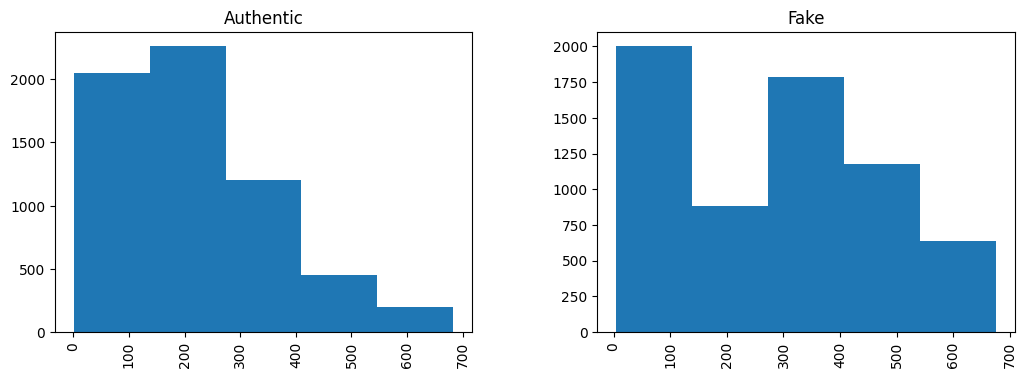

In [ ]:
#Plotting distribution of every tweet’s length for each Label [before text cleaning]

df.hist(column = 'word_count', by ='label',figsize=(12,4), bins = 5)

In [ ]:
corpus_list =[]
for i in range(len(df)):
    corpus_list +=df['Summary'][i]
counter=collections.Counter(corpus_list)
print(counter)

Counter({'के': 173083, 'एक': 35727, 'वीडियो': 30654, 'वायरल': 28112, 'यह': 24712, 'हमें': 23058, 'कहा': 16246, 'पोस्ट': 14127, 'ये': 13483, 'दावा': 12359, 'न्यूज': 11857, 'तस्वीर': 11699, 'सरकार': 11519, 'उन्होंने': 10272, 'मीडिया': 9719, 'कोई': 9470, 'वाली': 9423, 'यहां': 9334, 'यूजर': 9259, 'बताया': 9239, 'पहले': 8777, 'दिल्ली': 8561, 'हुआ': 8484, 'किसान': 8401, 'शेयर': 8376, 'ट्वीट': 8317, 'सोशल': 8248, 'मोदी': 7922, 'लिखा': 7874, 'बताएं': 7826, 'कुछ': 7753, 'फर्जी': 7694, 'साल': 7613, 'कोरोना': 7494, 'विश्वास': 7474, 'देश': 7458, 'जारी': 7325, 'नाम': 7253, 'भारत': 7077, 'सिर्फ': 6961, 'देखा': 6816, 'जानकारी': 6815, 'बात': 6784, 'लोगों': 6768, 'फरवरी': 6752, 'आंदोलन': 6731, 'अपने': 6656, 'लेकर': 6575, 'सच': 6515, 'पुलिस': 6493, 'कांग्रेस': 6445, 'आपके': 6365, 'दी': 6348, 'क्या': 6329, 'दौरान': 6300, 'खिलाफ': 6219, 'मदद': 6187, 'वाला': 6159, 'सहयोग': 5977, 'हमने': 5939, 'जिसमें': 5736, 'अलग': 5471, 'दिए': 5451, 'रिपोर्ट': 5445, 'संदेह': 5412, 'अफवाह': 5364, 'चुनाव': 5336, 'करें': 525

In [ ]:
corpus_list=[]
least_common = [word for word, word_count in Counter(corpus_list).most_common()[:-50:-1]]

# Function to filter out least common words from a list
def filter_least_common(words, least_common):
    return [word for word in words if word not in least_common]

# Apply the function to the 'Summary' column
df['Summary'] = df['Summary'].apply(lambda x: filter_least_common(x, least_common))

df.head(10)

,Unnamed: 0,Summary,label,word_count
0,0,"[सात, सालों, एक, दूसरे, बातआपको, जानकर, हैरानी, होगी, सुपरहिट, फिल्म, बॉलीवुड, अपने, करियर, शुरुआत, आमिर, खान, जूही, चावला, करीब, छह, सात, साल, बात, जैसा, जानते, आमिर, जूही, 90, के, दशक, के, सुपर, हिट, जोड़ियों, एक, आमिर, खान, सुपरहिट, फिल्म, कयामत, कयामत, बॉलीवुड, डेब्यू, जूही, चावला, फिल्म, सल्तनत, फिल्म, इंडस्ट्री, डेब्यू, दोनों, हिट, फिल्में, कीं, आमिर, जूही, लड़ाईजूही, चावला, अपनी, लड़ाई, याद, आमिर, खान, रविवार, बताया, फिल्म, इश्क, शूटिंग, के, दौरान, हमारी, छोटी, सी, बहस, लड़ाई, छोटी, मुझे, लगता, उस, दौरान, थोड़ा, घमंडी, मैंने, फैसला, मैं, उनसे, जूही, बात, करूंगा, सेट्स, मैं, उससे, दूरी, बनाए, मुझे, पता, मैंने, ऐसा, क्यों, शूट, ...]",Authentic,222
1,1,"[ममता, बनर्जी, फोटो, शेयर, बोले, प्रकाश, राज, मैं, जयकांत, शिकरे, बोल, हूं\, पश्चिम, बंगाल, बोले, शाह, मुझे, ममता, चोट, एहसास, क्‍या, दीदी, BJP, वर्कर्स, हत्या, दर्दपश्चिम, बंगाल, चुनाव, ममता, बड़ा, झटका, MLA, देबश्री, रॉय, इस्‍तीफा, नेता, बीजेपी, शामिलपश्चिम, बंगाल, चुनाव, पुरुलिया, बोलीं, ममता, बनर्जी, मेरा, दर्द, लोगों, परेशानियों, के, सामने, कुछ, नहींबंगाल, चुनाव, गडकरी, बोले, बंगाल, भुखमरी, गरीबी, पीड़ित, यहां, डबल, इंजन, सरकार, जबरदस्‍त, विकास, लाएगीTMC, CPM, बगावत, BJP, आए, ज्यादातर, नेताओं, मिली, CISF, सिक्योरिटी, जानिए, शामिलनंदीग्राम, हमले, चुनाव, आयोग, बड़ी, कार्रवाई, हटाए, ममता, बनर्जी, के, सुरक्षा, निदेशकIndiaoi, Ankur, Kumarकोलकाता, पश्चिम, बंगाल, मुख्‍यमंत्री, टीएमसी, मुखिया, ममता, बनर्जी, नंदीग्राम, हमले, लेकर, ...]",Authentic,286
2,2,"[असम, कांग्रेस, साधा, राजनाथ, सिंह, निशाना, कहा, धर्म, विशेष, के, लोगों, के, समर्थन, के, AIUDF, समझौताशरद, पवार, 5, राज्यों, के, चुनावी, नतीजों, भविष्यवाणी, जानें, किस, राज्य, बनेगी, किसकी, सरकारमध्य, प्रदेश, के, CM, शिवराज, मिशन, असम, BJP, प्रत्याशियों, के, करेंगे, चुनावी, सभाएं, 27, वोटिंगVIDEO, असम, कांग्रेस, बरसे, CM, शिवराज, कहा, महात्मा, गांधी, जिन्ना, के, रास्ते, चल, राहुलअसम, चुनावी, सभा, बोले, जेपी, नड्डा, कहा, कांग्रेस, सत्ता, आने, केवल, घोटाले, करेगीगुवाहाटी, बोले, अमित, शाह, बदरुद्दीन, अजमल, गोद, बैठाकर, कांग्रेस, ना, करें, असम, अस्मिता, बातअसम, योगेंद्र, यादव, जेल, बंद, राइजर, दल, के, अध्यक्ष, मुलाकात, कहा, बीजेपी, हराना, हमारा, लक्ष्यIndiaoi, Ashutosh, Tiwariनई, दिल्ली, एक, ओर, ...]",Authentic,289
3,3,"[सरवणन, टिकट, मिलने, नाराजगीरविवार, सुबह, तिरुप्पारनकुंद्रम, सीट, द्रमुक, मुनेत्र, कड़गम, विधायक, पी, सरवणन, भाजपा, सदस्यता, हासिल, ली, 2019, उपचुनाव, तुरुप्पारनकुंद्रम, सीट, चुनाव, जीते, डीएमके, के, सीटिंग, विधायक, के, बीजेपी, ज्वाइन, खबर, जहां, चौंकाया, वहीं, सिर्फ, कुछ, घंटों, जारी, बीजेपी, उम्मीदवारों, सूची, नाम, शामिल, उससे, ज्यादा, चौंकाया, खासकर, बीजेपी, के, स्थानीय, कार्यकर्ताओं, मदुरई, उत्तर, सीट, पी, सरवणन, टिकट, दिए, जाने, बीजेपी, के, कार्यकर्ताओं, विरोध, शुरू, न्यू, इंडियन, एक्सप्रेस, खबर, के, मुताबिक, पार्टी, के, स्थानीय, नेताओं, कहा, यह, बहुत, दुखद, पार्टी, नेतृत्व, लंबे, समय, पार्टी, के, काम, कार्यकर्ताओं, उपेक्षा, दी, हमसे, नए, नए, पार्टी, शामिल, के, काम, एक, बीजेपी, नेता, सवाल, उठाया, ...]",Authentic,287
4,4,"[दिल, धक, धक, गर्ल, माधुरी, दीक्षित, के, आमिर, सिर्फ, एक, दो, फिल्म, काम, जिसमें, दोनों, फिल्म, दिल, सुपरहिट, दिल, माधुरी, के, आमिर, खान, एक, बड़ा, लिपलॉक, सीन, जिसने, पर्दे, आग, लगा, दी, राजा, हिंदुस्तानीसाल, 1996, आई, ये, फिल्म, आमिर, खान, के, करियर, के, माइलस्टोन, साबित, धर्मेंश, दर्शन, फिल्म, सफलता, आमिर, करिश्मा, के, लिपलॉक, सीन, बहुत, बड़ा, हाथ, इश्कसाल, 1997, आयी, उनकी, हिट, फिल्म, इश्क, उन्होंने, एक, बार, फिर, जूही, चावला, के, लिपलॉक, सीन, गुलामसाल, 1998, आमिर, खान, विक्रम, भट्ट, फिल्म, गुलाम, रानी, मुखर्जी, के, किसिंग, सीन, देकर, पर्दे, आग, लगा, दी, 3, इडियट्ससाल, 2009, मेगाहिट, फिल्म, 3, इडियट्स, करीना, कपूर, ...]",Authentic,174
5,5,"[वो, ये, सब, करके, ना, सिर्फ, मजे, बल्कि, इससे, मेरी, इमेज, खराब, टाइम्स, ऑफ, इंडिया, खबर, के, मुताबिक, गोविंदा, पूछा, द, कपिल, शर्मा, शो, कृष्ण, अभिषेक, आपका, मजाक, क्यों, उड़ाते, \nगोविंदा, कहा, मुझे, पता, उनसे, ये, सब, करवा, अच्छे, लड़का, वो, ये, सब, करके, ना, सिर्फ, मजे, बल्कि, इससे, मेरी, इमेज, खराब, पीछे, वो, चाहता, हमारे, बीच, कुछ, सही, ना, बता, दें, गोविंदा, कृष्णा, अभिषेक, के, बीच, खराब, रिश्ते, बात, उस,

In [ ]:
# Assuming 'df' is your DataFrame containing the dataset
num_records = len(df_fake)

print(f"The dataset has {num_records} records.")

The dataset has 6487 records.


In [ ]:
# Splitting the dataset
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_texts, train_labels = train_df['Summary'].values, train_df['label'].values
test_texts, test_labels = test_df['Summary'].values, test_df['label'].values

In [ ]:

# Handle NaN or empty values in the text column
df['Summary'].fillna('', inplace=True)

# Define features (X) and labels (y)
X = df['Summary']
y = df['label']

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_texts, train_labels = train_df['Summary'].tolist(), train_df['label'].values
test_texts, test_labels = test_df['Summary'].tolist(), test_df['label'].values

# Ensure all elements in train_texts and test_texts are strings
train_texts = [str(text) for text in train_texts]
test_texts = [str(text) for text in test_texts]

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(train_texts)
X_test_tfidf = vectorizer.transform(test_texts)


# Train the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_tfidf, train_labels)

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred, average='weighted')
recall = recall_score(test_labels, y_pred, average='weighted')
f1 = f1_score(test_labels, y_pred, average='weighted')

accuracy_percentage = accuracy * 100
precision_percentage = precision * 100
recall_percentage = recall * 100
f1_percentage = f1 * 100

print(f'Accuracy: {accuracy_percentage:.2f}%')
print(f'Precision: {precision_percentage:.2f}')
print(f'Recall: {recall_percentage:.2f}')
print(f'F1-score: {f1_percentage:.2f}')

Accuracy: 96.99%
Precision: 97.07
Recall: 96.99
F1-score: 97.00


In [ ]:

from sklearn.ensemble import RandomForestClassifier


# Handle NaN or empty values in the text column
df['Summary'].fillna('', inplace=True)

# Define features (X) and labels (y)
X = df['Summary']
y = df['label']

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_texts, train_labels = train_df['Summary'].tolist(), train_df['label'].values
test_texts, test_labels = test_df['Summary'].tolist(), test_df['label'].values


# Ensure all elements in train_texts and test_texts are strings
train_texts = [str(text) for text in train_texts]
test_texts = [str(text) for text in test_texts]

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(train_texts)
X_test_tfidf = vectorizer.transform(test_texts)


# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf,train_labels)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred, average='weighted')
recall = recall_score(test_labels, y_pred, average='weighted')
f1 = f1_score(test_labels, y_pred, average='weighted')

accuracy_percentage = accuracy * 100
precision_percentage = precision * 100
recall_percentage = recall * 100
f1_percentage = f1 * 100

print(f'Accuracy: {accuracy_percentage:.2f}%')
print(f'Precision: {precision_percentage:.2f}')
print(f'Recall: {recall_percentage:.2f}')
print(f'F1-score: {f1_percentage:.2f}')


In [ ]:
!pip install wordcloud

from indicnlp.tokenize import indic_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth',None)   # this displays the dataframe in full width
import collections
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re
import nltk
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.ensemble import RandomForestClassifier
